In [1]:
# Install required packages
!pip install -q ultralytics
!pip install -q albumentations
!pip install -q torch torchvision
!pip install -q pyyaml
!pip install -q wandb
!pip install -q torchsummary

In [2]:
# Import necessary libraries
import os
import wandb
import pandas as pd
from pathlib import Path
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import yaml
from albumentations import Compose, RandomRotate90, Flip, Transpose, ShiftScaleRotate, RandomBrightnessContrast
from ultralytics import YOLO
import torch
import torch.nn as nn
import torch.nn.functional as F

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Setup wandb securely
# It's recommended to set the WANDB_API_KEY as an environment variable for security
# For example, in your environment, set WANDB_API_KEY=your_key
# Here, we retrieve it using os.getenv. If not set, you can manually input or handle accordingly.
wandb_api_key = '4f88ff0bbc6e3485258bca7079d7da4c47798ccd' #os.getenv('WANDB_API_KEY')
if wandb_api_key:
    wandb.login(key=wandb_api_key)
    print("Wandb login successful.")
else:
    # Handle the absence of the API key appropriately
    # For security, avoid hardcoding the key. Instead, prompt the user or skip logging in.
    print("Wandb API key not found. Skipping wandb login.")

# # Initialize a new wandb run (only if logged in)
# if wandb_api_key:
#     wandb.init(project='vincxr_yolov8x_balanceMax_HPYOLOv8_ChestXray', name='time11hour', reinit=True)

# Define paths to data directories
ROOT = Path("/kaggle/input/vinbigdata-yolo-dataset-with-wbf-640px-16class/vinbigdata-yolo-dataset-with-wbf-640px-16class")


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Wandb login successful.


In [4]:
from typing import List

def ls(path: Path) -> List[Path]:
    """List all files and directories in the given path."""
    return list(path.iterdir())

In [5]:
# List contents of ROOT to verify data structure
print("Contents of ROOT directory:")
for item in ls(ROOT):
    print(item)

Contents of ROOT directory:
/kaggle/input/vinbigdata-yolo-dataset-with-wbf-640px-16class/vinbigdata-yolo-dataset-with-wbf-640px-16class/val.txt
/kaggle/input/vinbigdata-yolo-dataset-with-wbf-640px-16class/vinbigdata-yolo-dataset-with-wbf-640px-16class/test.txt
/kaggle/input/vinbigdata-yolo-dataset-with-wbf-640px-16class/vinbigdata-yolo-dataset-with-wbf-640px-16class/data.yaml
/kaggle/input/vinbigdata-yolo-dataset-with-wbf-640px-16class/vinbigdata-yolo-dataset-with-wbf-640px-16class/train.txt
/kaggle/input/vinbigdata-yolo-dataset-with-wbf-640px-16class/vinbigdata-yolo-dataset-with-wbf-640px-16class/val
/kaggle/input/vinbigdata-yolo-dataset-with-wbf-640px-16class/vinbigdata-yolo-dataset-with-wbf-640px-16class/test
/kaggle/input/vinbigdata-yolo-dataset-with-wbf-640px-16class/vinbigdata-yolo-dataset-with-wbf-640px-16class/train


In [6]:
import numpy as np

# Number of images per class
class_counts = [5481, 255, 851, 4046, 519, 904, 1097, 2188, 2324, 1945, 2190, 4308, 195, 4097, 15525, 29347]

# Compute class-balanced weights
beta = 0.9999
effective_num = 1.0 - np.power(beta, class_counts)
weights = (1.0 - beta) / effective_num
weights = weights / np.sum(weights) * len(class_counts)

# Assign to device dynamically
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = torch.tensor(weights).float().to(device)
print(f"Using device: {device}")

# Define Class-balanced Focal Loss
class CBFocalLoss(nn.Module):
    """
    Class-Balanced Focal Loss to address class imbalance.
    """
    def __init__(self, weights, gamma=2.0):
        super().__init__()
        self.weights = weights
        self.gamma = gamma
        
    def forward(self, logits, labels):
        """
        Compute the focal loss between `logits` and the ground truth `labels`.

        Args:
            logits (Tensor): Predicted logits with shape (N, C).
            labels (Tensor): Ground truth class indices with shape (N,).

        Returns:
            Tensor: Scalar loss value.
        """
        ce_loss = F.cross_entropy(logits, labels, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (self.weights[labels] * (1 - pt)**self.gamma * ce_loss).mean()
        return focal_loss

Using device: cuda


In [7]:
# Initialize the updated loss function
focal_loss = CBFocalLoss(weights).to(device)

In [8]:
# Use callbacks to monkey-patch the YOLODataset class with a weighted dataset
def patch_dataset(trainer):
    """
    Monkey-patch the YOLODataset to implement a weighted dataset for class balancing.

    Args:
        trainer: The YOLO trainer instance.
    """
    from ultralytics.data.dataset import YOLODataset
    import ultralytics.data.build as build
    import numpy as np

    class YOLOWeightedDataset(YOLODataset):
        """
        A weighted dataset that samples images based on class frequencies.
        """
        def __init__(self, *args, mode="train", **kwargs):
            super(YOLOWeightedDataset, self).__init__(*args, **kwargs)
            self.train_mode = "train" in self.prefix
            self.count_instances()
            class_weights = np.sum(self.counts) / self.counts
            self.class_weights = np.array(class_weights)
            self.weights = self.calculate_weights()
            self.probabilities = self.calculate_probabilities()

        def count_instances(self):
            """Count the number of instances per class."""
            self.counts = [0 for _ in range(len(self.data["names"]))]
            for label in self.labels:
                cls = label['cls'].reshape(-1).astype(int)
                for id in cls:
                    self.counts[id] += 1
            self.counts = np.array(self.counts)
            self.counts = np.where(self.counts == 0, 1, self.counts)

        def calculate_weights(self):
            """Calculate weights for each label based on class weights."""
            weights = []
            for label in self.labels:
                cls = label['cls'].reshape(-1).astype(int)
                if cls.size == 0:
                    weights.append(1)
                    continue
                weight = np.max(self.class_weights[cls])
                weights.append(weight)
            return weights

        def calculate_probabilities(self):
            """Calculate sampling probabilities based on weights."""
            total_weight = sum(self.weights)
            probabilities = [w / total_weight for w in self.weights]
            return probabilities

        def __getitem__(self, index):
            """
            Get an item by sampling based on probabilities during training.

            Args:
                index (int): Index of the data.

            Returns:
                Tuple: Transformed image and labels.
            """
            if not self.train_mode:
                return self.transforms(self.get_image_and_label(index))
            else:
                sampled_index = np.random.choice(len(self.labels), p=self.probabilities)
                return self.transforms(self.get_image_and_label(sampled_index))

    # Apply the monkey-patch
    build.YOLODataset = YOLOWeightedDataset
    print("YOLODataset has been monkey-patched with YOLOWeightedDataset.")

In [9]:
# # Define custom modules and loss functions
# class DyReLU(nn.Module):
#     """
#     Dynamic ReLU activation function with adaptive coefficients.
#     """
#     def __init__(self, channels, reduction=4, k=2, conv_type='2d'):
#         super(DyReLU, self).__init__()
#         self.channels = channels
#         self.k = k
#         self.conv_type = conv_type
#         assert self.conv_type in ['1d', '2d'], "conv_type must be '1d' or '2d'"

#         self.fc1 = nn.Linear(channels, channels // reduction)
#         self.relu = nn.ReLU(inplace=True)
#         self.fc2 = nn.Linear(channels // reduction, 2*k)
#         self.sigmoid = nn.Sigmoid()

#         self.register_buffer('lambdas', torch.Tensor([1.]*k + [0.5]*k).float())
#         self.register_buffer('init_v', torch.Tensor([1.] + [0.]*(2*k - 1)).float())

#     def get_relu_coefs(self, x):
#         theta = torch.mean(x, dim=-1)
#         if self.conv_type == '2d':
#             theta = torch.mean(theta, dim=-1)
#         theta = self.fc1(theta)
#         theta = self.relu(theta)
#         theta = self.fc2(theta)
#         theta = 2 * self.sigmoid(theta) - 1
#         return theta

#     def forward(self, x):
#         assert x.shape[1] == self.channels, f"Expected input with {self.channels} channels, got {x.shape[1]}"
#         theta = self.get_relu_coefs(x)
#         relu_coefs = theta.view(-1, self.channels, 2*self.k) * self.lambdas + self.init_v

#         if self.conv_type == '2d':
#             # (B, C, H, W) -> (B, C, H, W, 1)
#             x_perm = x.unsqueeze(-1)
#             output = x_perm * relu_coefs[:, :, :self.k] + relu_coefs[:, :, self.k:]
#             result = torch.max(output, dim=-1)[0]
#         else:
#             # (B, C, L) -> (B, C, L, 1)
#             x_perm = x.unsqueeze(-1)
#             output = x_perm * relu_coefs[:, :, :self.k] + relu_coefs[:, :, self.k:]
#             result = torch.max(output, dim=-1)[0]
#         return result

# class DMBottleneck(nn.Module):
#     """
#     Bottleneck module with OSRA, IDConv, and STE components.
#     """
#     def __init__(self, c1, c2):
#         super().__init__()
#         self.split = nn.Sequential(
#             nn.Conv2d(c1, c1 // 2, kernel_size=1, bias=False),
#             nn.BatchNorm2d(c1 // 2),
#             nn.SiLU()
#         )
#         self.osra = OSRA(c1 // 2, c2 // 2)
#         self.idconv = IDConv(c1 // 2, c2 // 2)
#         self.ste = STE(c2)

#     def forward(self, x):
#         x1, x2 = self.split(x).chunk(2, dim=1)
#         x1 = self.osra(x1)
#         x2 = self.idconv(x2)
#         x = torch.cat([x1, x2], dim=1)
#         x = self.ste(x)
#         return x

# class OSRA(nn.Module):
#     """
#     OSRA module for attention on spatial regions.
#     """
#     def __init__(self, c1, c2):
#         super().__init__()
#         self.conv = nn.Conv2d(c1, c2, kernel_size=3, padding=1, bias=False)
#         self.bn = nn.BatchNorm2d(c2)
#         self.act = nn.SiLU()

#     def forward(self, x):
#         x = self.conv(x)
#         x = self.bn(x)
#         x = self.act(x)
#         return x

# class IDConv(nn.Module):
#     """
#     IDConv module for identity-based convolution.
#     """
#     def __init__(self, c1, c2, r=4):
#         super().__init__()
#         self.conv1 = nn.Conv2d(c1, c1 // r, kernel_size=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(c1 // r)
#         self.act1 = nn.SiLU()
#         self.conv2 = nn.Conv2d(c1 // r, c2, kernel_size=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(c2)
#         self.act2 = nn.SiLU()

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.act1(x)
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.act2(x)
#         return x

# class STE(nn.Module):
#     """
#     STE module for shortcut and transformation.
#     """
#     def __init__(self, c, r=4):
#         super().__init__()
#         self.conv1 = nn.Conv2d(c, c // r, kernel_size=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(c // r)
#         self.act1 = nn.SiLU()
#         self.conv2 = nn.Conv2d(c // r, c, kernel_size=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(c)
#         self.act2 = nn.SiLU()

#     def forward(self, x):
#         shortcut = x
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.act1(x)
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.act2(x)
#         x = x + shortcut
#         return x

# class C2fDM(nn.Module):
#     """
#     C2fDM module replacing C2f with customizable depth and shortcut.
#     """
#     def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):
#         super().__init__()
#         self.c = int(c2 * e)
#         self.cv1 = nn.Conv2d(c1, 2 * self.c, kernel_size=1, bias=False)
#         self.cv2 = nn.Conv2d((2 + n) * self.c, c2, kernel_size=1, bias=False)
#         self.bn = nn.BatchNorm2d(2 * self.c)
#         self.act = nn.SiLU()
#         self.m = nn.Sequential(*(DMBottleneck(self.c, self.c) for _ in range(n)))
#         self.shortcut = shortcut
#         if self.shortcut:
#             self.shortcut_conv = nn.Conv2d(c1, c2, kernel_size=1, bias=False)
#             self.shortcut_bn = nn.BatchNorm2d(c2)

#     def forward(self, x):
#         residual = x
#         x = self.cv1(x)
#         x = self.bn(x)
#         x = self.act(x)
#         x1, x2 = x.chunk(2, dim=1)
#         x2 = self.m(x2)
#         x = torch.cat([x1, x2], dim=1)
#         if self.shortcut:
#             residual = self.shortcut_bn(self.shortcut_conv(residual))
#             x = x + residual  # Perform correct addition
#         x = self.cv2(x)
#         return x

# class BRA(nn.Module):
#     """
#     BRA module for attention mechanisms focusing on important image regions.
#     """
#     def __init__(self, c, num_regions=5, s=8):
#         super().__init__()
#         self.q = nn.Linear(c, c, bias=False)
#         self.k = nn.Linear(c, c, bias=False)
#         self.v = nn.Linear(c, c, bias=False)
#         self.s = s
#         self.num_regions = num_regions

#     def forward(self, x):
#         b, c, h, w = x.shape
#         x = x.reshape(b, c, -1).permute(0, 2, 1)  # (batch, seq_len, c)
#         q = self.q(x)
#         k = self.k(x)
#         v = self.v(x)
#         q = q.reshape(b, -1, self.s, c // self.s).permute(0, 2, 1, 3)
#         k = k.reshape(b, -1, self.s, c // self.s).permute(0, 2, 3, 1)
#         v = v.reshape(b, -1, self.s, c // self.s).permute(0, 2, 1, 3)
#         attn = (q @ k.transpose(-2, -1)) * (1.0 / torch.sqrt(torch.tensor(k.size(-1), dtype=torch.float32)))
#         attn = attn.softmax(dim=-1)
#         x = (attn @ v).transpose(1, 2).reshape(b, h, w, c)
#         x = x.permute(0, 3, 1, 2)
#         return x

# class BGFPN(nn.Module):
#     """
#     BGFPN module utilizing BRA to enhance multi-scale processing capabilities.
#     """
#     def __init__(self, c1_list, c2, n=1, shortcut=False, g=1, e=0.5):
#         super().__init__()
#         total_c1 = sum(c1_list)
#         self.cv1 = nn.Conv2d(total_c1, c2, kernel_size=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(c2)
#         self.act1 = nn.SiLU()
#         self.cv2 = nn.Conv2d(c2, c2, kernel_size=3, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(c2)
#         self.act2 = nn.SiLU()
#         self.bra = BRA(c2)
#         self.m = nn.Sequential(*(C2fDM(c2, c2, n, shortcut, g, e) for _ in range(n)))

#     def forward(self, *inputs):
#         """
#         Forward pass for BGFPN.

#         Args:
#             *inputs: Variable number of input feature maps.

#         Returns:
#             Tensor: Output feature map after processing.
#         """
#         x = torch.cat(inputs, dim=1)
#         x = self.cv1(x)
#         x = self.bn1(x)
#         x = self.act1(x)
#         x = self.cv2(x)
#         x = self.bn2(x)
#         x = self.act2(x)
#         x = self.bra(x)
#         x = self.m(x)
#         return x

# class SMPDIoU(nn.Module):
#     """
#     SMPDIoU loss function for optimizing bounding box regression.
#     """
#     def __init__(self, alpha=0.5):
#         super().__init__()
#         self.alpha = alpha

#     def forward(self, pred, target):
#         """
#         Compute the SMPDIoU loss between predicted and target bounding boxes.

#         Args:
#             pred (Tensor): Predicted bounding boxes with shape (N, 4).
#             target (Tensor): Ground truth bounding boxes with shape (N, 4).

#         Returns:
#             Tensor: Scalar loss value.
#         """
#         # Split bounding box components
#         pred_left, pred_top, pred_right, pred_bottom = pred[:, 0], pred[:, 1], pred[:, 2], pred[:, 3]
#         target_left, target_top, target_right, target_bottom = target[:, 0], target[:, 1], target[:, 2], target[:, 3]

#         # Compute areas
#         target_area = (target_left + target_right) * (target_top + target_bottom)
#         pred_area = (pred_left + pred_right) * (pred_top + pred_bottom)

#         # Compute intersection areas
#         w_intersect = torch.min(pred_left, target_left) + torch.min(pred_right, target_right)
#         h_intersect = torch.min(pred_bottom, target_bottom) + torch.min(pred_top, target_top)
#         area_intersect = w_intersect * h_intersect
#         area_union = target_area + pred_area - area_intersect
#         iou = area_intersect / area_union

#         # Compute additional loss components
#         delta_w = torch.abs(pred_left - target_left) + torch.abs(pred_right - target_right)
#         delta_h = torch.abs(pred_top - target_top) + torch.abs(pred_bottom - target_bottom)
#         distance_loss = torch.sum(1 - torch.exp(-delta_w)) + torch.sum(1 - torch.exp(-delta_h))

#         omega_w = (torch.abs(pred_left - target_left) + torch.abs(pred_right - target_right)) / torch.max(pred_left + pred_right, target_left + target_right)
#         omega_h = (torch.abs(pred_top - target_top) + torch.abs(pred_bottom - target_bottom)) / torch.max(pred_top + pred_bottom, target_top + target_bottom)
#         shape_loss = torch.sum(1 - torch.exp(-omega_w ** 4)) + torch.sum(1 - torch.exp(-omega_h ** 4))

#         # Compute perpendicular distance
#         pred_center_x = (pred_left + pred_right) / 2
#         pred_center_y = (pred_top + pred_bottom) / 2
#         target_center_x = (target_left + target_right) / 2
#         target_center_y = (target_top + target_bottom) / 2

#         perpendicular_distance = torch.sqrt((pred_center_x - target_center_x) ** 2 + (pred_center_y - target_center_y) ** 2)
#         max_distance = torch.sqrt(target_left ** 2 + target_top ** 2)
#         normalized_distance = perpendicular_distance / max_distance

#         # Compute SMPDIoU loss
#         smpdiou = self.alpha * (1 - iou) + (1 - self.alpha) * (distance_loss + shape_loss)
#         smpdiou = torch.clamp(smpdiou, min=0)  # Ensure non-negative
#         return smpdiou.mean()

# class Fusion(nn.Module):
#     """
#     Fusion module to replace Concat, combining two feature maps.
#     """
#     def __init__(self, c1, c2):
#         super().__init__()
#         self.conv = nn.Conv2d(c1 + c2, c2, kernel_size=1, bias=False)
#         self.bn = nn.BatchNorm2d(c2)
#         self.act = nn.SiLU()

#     def forward(self, x1, x2):
#         """
#         Forward pass for Fusion.

#         Args:
#             x1 (Tensor): First input feature map.
#             x2 (Tensor): Second input feature map.

#         Returns:
#             Tensor: Combined feature map after convolution and activation.
#         """
#         x = torch.cat([x1, x2], dim=1)
#         x = self.conv(x)
#         x = self.bn(x)
#         x = self.act(x)
#         return x

# class BiFormer(nn.Module):
#     """
#     BiFormer module for attention mechanisms.
#     """
#     def __init__(self, c):
#         super().__init__()
#         self.attn = nn.MultiheadAttention(c, num_heads=8, batch_first=True)
#         self.ln = nn.LayerNorm(c)

#     def forward(self, x):
#         """
#         Forward pass for BiFormer.

#         Args:
#             x (Tensor): Input feature map with shape (B, C, H, W).

#         Returns:
#             Tensor: Output feature map after attention and normalization.
#         """
#         b, c, h, w = x.shape
#         x_flat = x.view(b, c, -1).permute(0, 2, 1)  # (B, L, C)
#         attn_output, _ = self.attn(x_flat, x_flat, x_flat)
#         attn_output = self.ln(attn_output + x_flat)
#         x = attn_output.permute(0, 2, 1).view(b, c, h, w)
#         return x

# # Helper functions to get in/out channels
# def get_out_channels(layer):
#     """
#     Recursively get the number of output channels for a given layer.

#     Args:
#         layer (nn.Module): The layer to inspect.

#     Returns:
#         int: Number of output channels.
#     """
#     if hasattr(layer, 'out_channels'):
#         return layer.out_channels
#     elif hasattr(layer, 'conv'):
#         return layer.conv.out_channels
#     elif hasattr(layer, 'conv2d'):
#         return layer.conv2d.out_channels
#     elif hasattr(layer, 'cv2'):
#         return get_out_channels(layer.cv2)
#     elif hasattr(layer, 'cv'):
#         return get_out_channels(layer.cv)
#     else:
#         for sublayer in reversed(list(layer.children())):
#             out_channels = get_out_channels(sublayer)
#             if out_channels > 0:
#                 return out_channels
#         return 0

# def get_in_channels(layer):
#     """
#     Recursively get the number of input channels for a given layer.

#     Args:
#         layer (nn.Module): The layer to inspect.

#     Returns:
#         int: Number of input channels.
#     """
#     if hasattr(layer, 'in_channels'):
#         return layer.in_channels
#     elif hasattr(layer, 'conv'):
#         return layer.conv.in_channels
#     elif hasattr(layer, 'conv2d'):
#         return layer.conv2d.in_channels
#     elif hasattr(layer, 'cv1'):
#         return get_in_channels(layer.cv1)
#     elif hasattr(layer, 'cv'):
#         return get_in_channels(layer.cv)
#     else:
#         for sublayer in list(layer.children()):
#             in_channels = get_in_channels(sublayer)
#             if in_channels > 0:
#                 return in_channels
#         return 0

In [10]:
# # Main HPYOLOv8 class with custom modifications
# class HPYOLOv8(nn.Module):
#     """
#     HPYOLOv8 class that extends the YOLOv8 model with custom modifications.
#     """
#     def __init__(self, model_path='yolov8x.pt'):
#         super().__init__()
#         self.model = YOLO(model_path)

#         # Ensure that the DyReLU activation is correctly replacing SiLU
#         for name, module in model.model.model.named_modules():
#             if isinstance(module, nn.SiLU):
#                 parent_name = '.'.join(name.split('.')[:-1])
#                 layer_name = name.split('.')[-1]
#                 parent = model.model.model
#                 if parent_name:
#                     for n in parent_name.split('.'):
#                         parent = getattr(parent, n)
#                 if hasattr(parent, 'conv'):
#                     out_channels = parent.conv.out_channels
#                     new_act = DyReLU(out_channels)
#                     setattr(parent, layer_name, new_act)
#                     print(f"Replaced SiLU with DyReLU in layer: {name}")
#                 else:
#                     print(f"Skipped replacement for layer: {name} (no 'conv' attribute)")

#         # Replace C2f with C2fDM in Backbone
#         for i, layer in enumerate(self.model.model.model):
#             if isinstance(layer, nn.Sequential):
#                 for j, sublayer in enumerate(layer):
#                     if type(sublayer).__name__ == "C2f":
#                         print(f"Layer {i}.{j} is C2f, replacing with C2fDM.")
#                         c1 = sublayer.cv1.conv.in_channels if hasattr(sublayer, 'cv1') and hasattr(sublayer.cv1, 'conv') else get_in_channels(sublayer.cv1)
#                         c2 = sublayer.cv2.conv.out_channels if hasattr(sublayer, 'cv2') and hasattr(sublayer.cv2, 'conv') else get_out_channels(sublayer.cv2)
#                         c2fdm = C2fDM(c1, c2)
#                         self.model.model.model[i][j] = c2fdm
#                         print(f"Replaced C2f with C2fDM in layer {i}.{j}.")
#             elif type(layer).__name__ == "C2f":
#                 print(f"Layer {i} is C2f, replacing with C2fDM.")
#                 c1 = layer.cv1.conv.in_channels if hasattr(layer, 'cv1') and hasattr(layer.cv1, 'conv') else get_in_channels(layer.cv1)
#                 c2 = layer.cv2.conv.out_channels if hasattr(layer, 'cv2') and hasattr(layer.cv2, 'conv') else get_out_channels(layer.cv2)
#                 c2fdm = C2fDM(c1, c2)
#                 self.model.model.model[i] = c2fdm
#                 print(f"Replaced C2f with C2fDM in layer {i}.")

#         # Replace Concat with Fusion and add BiFormer in Neck
#         i = 0
#         while i < len(self.model.model.model):
#             layer = self.model.model.model[i]
#             if type(layer).__name__ == "Concat":
#                 print(f"Layer {i} is Concat, replacing with Fusion and adding BiFormer.")
#                 c1 = 0
#                 for idx in layer.f:
#                     if idx < len(self.model.model.model):
#                         prev_layer = self.model.model.model[idx]
#                         out_channels = get_out_channels(prev_layer)
#                         c1 += out_channels
#                     else:
#                         print(f"Invalid layer index {idx} in Concat layer {i}. Skipping.")
#                 if i + 1 < len(self.model.model.model):
#                     next_layer = self.model.model.model[i + 1]
#                     c2 = get_in_channels(next_layer)
#                 else:
#                     c2 = c1
#                 fusion_layer = Fusion(c1, c2)
#                 biformer_layer = BiFormer(c1)
#                 # Replace Concat with BiFormer and Fusion
#                 self.model.model.model[i] = nn.Sequential(biformer_layer, fusion_layer)
#                 print(f"Replaced layer {i} with BiFormer and Fusion.")
#                 i += 1
#             else:
#                 i += 1

#         # Replace FPN with BGFPN
#         try:
#             detect_layer = self.model.model.model[-1]
#             in_channels_list = [detect_layer.cv2[i][0].conv.in_channels for i in range(3)]
#             in_channels_list.insert(0, self.model.model.model[-4].conv.out_channels)
#             out_channels = detect_layer.cv2[0][-1].conv.out_channels if hasattr(detect_layer.cv2[0][-1], 'conv') else get_out_channels(detect_layer.cv2[0][-1])
#             bgfpn = BGFPN(in_channels_list, out_channels)
#             self.model.model.model[-1] = bgfpn
#             print("Replaced FPN with BGFPN.")
#         except Exception as e:
#             print(f"Failed to replace FPN with BGFPN: {e}")

#         # Replace CIoU Loss with SMPDIoU and add CBFocalLoss
#         try:
#             self.model.model.model[-1].loss = SMPDIoU(alpha=0.75)  # Replace CIoU with SMPDIoU
#             self.focal_loss = CBFocalLoss(weights)  # Add CBFocalLoss
#             print("Replaced CIoU loss with SMPDIoU and added CBFocalLoss.")
#         except Exception as e:
#             print(f"Failed to replace loss functions: {e}")
            

#         # Verify that Fusion and BiFormer are correctly integrated
#         for i, layer in enumerate(model.model.model):
#             if isinstance(layer, Fusion) or isinstance(layer, BiFormer):
#                 print(f"Layer {i} is correctly replaced with {type(layer).__name__}")

#     def add_callback(self, event, func):
#         """
#         Forward the add_callback method to the internal YOLO model.

#         Args:
#             event (str): The event to attach the callback to.
#             func (callable): The callback function.
#         """
#         if hasattr(self.model, 'add_callback'):
#             self.model.add_callback(event, func)
#             print(f"Added callback for event '{event}'.")
#         else:
#             raise AttributeError(f"'YOLO' object has no attribute 'add_callback'")

#     def forward(self, x):
#         """Forward pass through the YOLO model."""
#         return self.model(x)

#     def train_model(self, **kwargs):
#         """Train the YOLO model with given parameters."""
#         return self.model.train(**kwargs)

#     def val(self, **kwargs):
#         """Validate the YOLO model with given parameters."""
#         return self.model.val(**kwargs)
    
#     def compute_loss(self, pred_boxes, gt_boxes, pred_classes, gt_classes):
#         """
#         Compute the combined SMPDIoU and CBFocalLoss.

#         Args:
#             pred_boxes (Tensor): Predicted bounding boxes.
#             gt_boxes (Tensor): Ground truth bounding boxes.
#             pred_classes (Tensor): Predicted class logits.
#             gt_classes (Tensor): Ground truth class indices.

#         Returns:
#             Tensor: Combined loss value.
#         """
#         # Combine box loss (SMPDIoU) and classification loss (CBFocalLoss)
#         box_loss = self.model.model.model[-1].loss(pred_boxes, gt_boxes)

#         # Compute classification loss
#         class_loss = self.focal_loss(pred_classes, gt_classes)
#         total_loss = box_loss + class_loss

#         # Check if loss is negative
#         if total_loss.item() < 0:
#             print("Warning: Loss is negative")

#         return total_loss

In [11]:
# Define custom modules and loss functions
import torch
import torch.nn as nn
import torch.nn.functional as F

class DyReLU(nn.Module):
    """
    Dynamic ReLU activation function with adaptive coefficients.
    """
    def __init__(self, channels, reduction=4, k=2, conv_type='2d'):
        super(DyReLU, self).__init__()
        self.channels = channels
        self.k = k
        self.conv_type = conv_type
        assert self.conv_type in ['1d', '2d'], "conv_type must be '1d' or '2d'"

        # Định nghĩa các lớp Linear với kích thước đúng
        self.fc1 = nn.Linear(channels, channels // reduction)          # Nhận đầu vào C, trả về C//reduction
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channels // reduction, channels * 2 * k)  # Nhận đầu vào C//reduction, trả về C * 2 * k
        self.sigmoid = nn.Sigmoid()

        # Các hệ số cố định
        self.register_buffer('lambdas', torch.Tensor([1.]*k + [0.5]*k).float())
        self.register_buffer('init_v', torch.Tensor([1.] + [0.]*(2*k - 1)).float())

    def get_relu_coefs(self, x):
        """
        Tính toán các hệ số ReLU dựa trên đầu vào.
        """
        if self.conv_type == '2d':
            theta = torch.mean(x, dim=(2, 3))  # Trung bình theo chiều H và W: (B, C)
        else:
            theta = torch.mean(x, dim=-1)      # Trung bình theo chiều L: (B, C)
        theta = self.fc1(theta)               # (B, C//reduction)
        theta = self.relu(theta)              # (B, C//reduction)
        theta = self.fc2(theta)               # (B, C * 2 * k)
        theta = 2 * self.sigmoid(theta) - 1   # (B, C * 2 * k)
        return theta

    def forward(self, x):
        """
        Forward pass của DyReLU.
        """
        # Kiểm tra số kênh
        assert x.shape[1] == self.channels, f"Expected input with {self.channels} channels, got {x.shape[1]}"
        
        # Tính các hệ số ReLU
        theta = self.get_relu_coefs(x)  # (B, C * 2 * k)
        
        # Reshape để phù hợp với từng kênh
        relu_coefs = theta.view(-1, self.channels, 2 * self.k) * self.lambdas + self.init_v  # (B, C, 2*k)

        if self.conv_type == '2d':
            # (B, C, H, W) -> (B, C, H, W, 1)
            x_perm = x.unsqueeze(-1)  # (B, C, H, W, 1)
            # Broadcast relu_coefs tới các chiều không gian
            relu_coefs = relu_coefs.unsqueeze(2).unsqueeze(3)  # (B, C, 1, 1, 2*k)
            # Tính toán phần tích và cộng
            output = x_perm * relu_coefs[:, :, :, :, :self.k] + relu_coefs[:, :, :, :, self.k:]
            # Lấy giá trị lớn nhất theo chiều cuối cùng
            result = torch.max(output, dim=-1)[0]  # (B, C, H, W)
        else:
            # (B, C, L) -> (B, C, L, 1)
            x_perm = x.unsqueeze(-1)  # (B, C, L, 1)
            relu_coefs = relu_coefs.unsqueeze(2)  # (B, C, 1, 2*k)
            output = x_perm * relu_coefs[:, :, :, :self.k] + relu_coefs[:, :, :, self.k:]
            result = torch.max(output, dim=-1)[0]  # (B, C, L)
        return result

class DMBottleneck(nn.Module):
    """
    Bottleneck module with OSRA, IDConv, and STE components.
    """
    def __init__(self, c1, c2):
        super().__init__()
        self.split = nn.Sequential(
            nn.Conv2d(c1, c1 // 2, kernel_size=1, bias=False),
            nn.BatchNorm2d(c1 // 2),
            DyReLU(c1 // 2)  # Thay thế nn.SiLU() bằng DyReLU
        )
        self.osra = OSRA(c1 // 2, c2 // 2)
        self.idconv = IDConv(c1 // 2, c2 // 2)
        self.ste = STE(c2)

    def forward(self, x):
        x1, x2 = self.split(x).chunk(2, dim=1)
        x1 = self.osra(x1)
        x2 = self.idconv(x2)
        x = torch.cat([x1, x2], dim=1)
        x = self.ste(x)
        return x

class OSRA(nn.Module):
    """
    OSRA module for attention on spatial regions.
    """
    def __init__(self, c1, c2):
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, kernel_size=3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = DyReLU(c2)  # Thay thế nn.SiLU() bằng DyReLU

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

class IDConv(nn.Module):
    """
    IDConv module for identity-based convolution.
    """
    def __init__(self, c1, c2, r=4):
        super().__init__()
        self.conv1 = nn.Conv2d(c1, c1 // r, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(c1 // r)
        self.act1 = DyReLU(c1 // r)  # Thay thế nn.SiLU() bằng DyReLU
        self.conv2 = nn.Conv2d(c1 // r, c2, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(c2)
        self.act2 = DyReLU(c2)  # Thay thế nn.SiLU() bằng DyReLU

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        return x

class STE(nn.Module):
    """
    STE module for shortcut and transformation.
    """
    def __init__(self, c, r=4):
        super().__init__()
        self.conv1 = nn.Conv2d(c, c // r, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(c // r)
        self.act1 = DyReLU(c // r)  # Thay thế nn.SiLU() bằng DyReLU
        self.conv2 = nn.Conv2d(c // r, c, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(c)
        self.act2 = DyReLU(c)  # Thay thế nn.SiLU() bằng DyReLU

    def forward(self, x):
        shortcut = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = x + shortcut
        return x

class C2fDM(nn.Module):
    """
    C2fDM module replacing C2f with customizable depth and shortcut.
    """
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5, f=-1):
        super().__init__()
        self.f = f  # Thêm thuộc tính 'f'
        self.c = int(c2 * e)
        self.cv1 = nn.Conv2d(c1, 2 * self.c, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(2 * self.c)
        self.act = DyReLU(2 * self.c)  # Thay thế nn.SiLU() bằng DyReLU
        self.cv2 = nn.Conv2d((2 + n) * self.c, c2, kernel_size=1, bias=False)
        self.m = nn.Sequential(*(DMBottleneck(self.c, self.c) for _ in range(n)))
        self.shortcut = shortcut
        if self.shortcut:
            self.shortcut_conv = nn.Conv2d(c1, c2, kernel_size=1, bias=False)
            self.shortcut_bn = nn.BatchNorm2d(c2)
            self.shortcut_act = DyReLU(c2)  # Thêm DyReLU cho shortcut

    def forward(self, x):
        residual = x
        x = self.cv1(x)
        x = self.bn(x)
        x = self.act(x)
        x1, x2 = x.chunk(2, dim=1)
        x2 = self.m(x2)
        x = torch.cat([x1, x2], dim=1)
        if self.shortcut:
            residual = self.shortcut_conv(residual)
            residual = self.shortcut_bn(residual)
            residual = self.shortcut_act(residual)  # Áp dụng DyReLU cho shortcut
            x = x + residual  # Thực hiện phép cộng đúng cách
        x = self.cv2(x)
        return x

class BRA(nn.Module):
    """
    BRA module for attention mechanisms focusing on important image regions.
    """
    def __init__(self, c, num_regions=5, s=8):
        super().__init__()
        self.q = nn.Linear(c, c, bias=False)
        self.k = nn.Linear(c, c, bias=False)
        self.v = nn.Linear(c, c, bias=False)
        self.s = s
        self.num_regions = num_regions

    def forward(self, x):
        b, c, h, w = x.shape
        x = x.reshape(b, c, -1).permute(0, 2, 1)  # (batch, seq_len, c)
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        q = q.reshape(b, -1, self.s, c // self.s).permute(0, 2, 1, 3)
        k = k.reshape(b, -1, self.s, c // self.s).permute(0, 2, 3, 1)
        v = v.reshape(b, -1, self.s, c // self.s).permute(0, 2, 1, 3)
        attn = (q @ k.transpose(-2, -1)) * (1.0 / torch.sqrt(torch.tensor(k.size(-1), dtype=torch.float32)))
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(b, h, w, c)
        x = x.permute(0, 3, 1, 2)
        return x

class BGFPN(nn.Module):
    """
    BGFPN module utilizing BRA to enhance multi-scale processing capabilities.
    """
    def __init__(self, c1_list, c2, n=1, shortcut=False, g=1, e=0.5):
        super().__init__()
        total_c1 = sum(c1_list)
        self.cv1 = nn.Conv2d(total_c1, c2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(c2)
        self.act1 = DyReLU(c2)  # Thay thế nn.SiLU() bằng DyReLU
        self.cv2 = nn.Conv2d(c2, c2, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(c2)
        self.act2 = DyReLU(c2)  # Thay thế nn.SiLU() bằng DyReLU
        self.bra = BRA(c2)
        self.m = nn.Sequential(*(C2fDM(c2, c2, n, shortcut, g, e) for _ in range(n)))

    def forward(self, *inputs):
        """
        Forward pass for BGFPN.

        Args:
            *inputs: Variable number of input feature maps.

        Returns:
            Tensor: Output feature map after processing.
        """
        x = torch.cat(inputs, dim=1)
        x = self.cv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.cv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.bra(x)
        x = self.m(x)
        return x

class SMPDIoU(nn.Module):
    """
    SMPDIoU loss function for optimizing bounding box regression.
    """
    def __init__(self, alpha=0.5):
        super().__init__()
        self.alpha = alpha

    def forward(self, pred, target):
        """
        Compute the SMPDIoU loss between predicted and target bounding boxes.

        Args:
            pred (Tensor): Predicted bounding boxes with shape (N, 4).
            target (Tensor): Ground truth bounding boxes with shape (N, 4).

        Returns:
            Tensor: Scalar loss value.
        """
        # Split bounding box components
        pred_left, pred_top, pred_right, pred_bottom = pred[:, 0], pred[:, 1], pred[:, 2], pred[:, 3]
        target_left, target_top, target_right, target_bottom = target[:, 0], target[:, 1], target[:, 2], target[:, 3]

        # Compute areas
        target_area = (target_left + target_right) * (target_top + target_bottom)
        pred_area = (pred_left + pred_right) * (pred_top + pred_bottom)

        # Compute intersection areas
        w_intersect = torch.min(pred_left, target_left) + torch.min(pred_right, target_right)
        h_intersect = torch.min(pred_bottom, target_bottom) + torch.min(pred_top, target_top)
        area_intersect = w_intersect * h_intersect
        area_union = target_area + pred_area - area_intersect
        iou = area_intersect / area_union

        # Compute additional loss components
        delta_w = torch.abs(pred_left - target_left) + torch.abs(pred_right - target_right)
        delta_h = torch.abs(pred_top - target_top) + torch.abs(pred_bottom - target_bottom)
        distance_loss = torch.sum(1 - torch.exp(-delta_w)) + torch.sum(1 - torch.exp(-delta_h))

        omega_w = (torch.abs(pred_left - target_left) + torch.abs(pred_right - target_right)) / torch.max(pred_left + pred_right, target_left + target_right)
        omega_h = (torch.abs(pred_top - target_top) + torch.abs(pred_bottom - target_bottom)) / torch.max(pred_top + pred_bottom, target_top + target_bottom)
        shape_loss = torch.sum(1 - torch.exp(-omega_w ** 4)) + torch.sum(1 - torch.exp(-omega_h ** 4))

        # Compute perpendicular distance
        pred_center_x = (pred_left + pred_right) / 2
        pred_center_y = (pred_top + pred_bottom) / 2
        target_center_x = (target_left + target_right) / 2
        target_center_y = (target_top + target_bottom) / 2

        perpendicular_distance = torch.sqrt((pred_center_x - target_center_x) ** 2 + (pred_center_y - target_center_y) ** 2)
        max_distance = torch.sqrt(target_left ** 2 + target_top ** 2)
        normalized_distance = perpendicular_distance / max_distance

        # Compute SMPDIoU loss
        smpdiou = self.alpha * (1 - iou) + (1 - self.alpha) * (distance_loss + shape_loss)
        smpdiou = torch.clamp(smpdiou, min=0)  # Ensure non-negative
        return smpdiou.mean()

class Fusion(nn.Module):
    """
    Fusion module to replace Concat, combining two feature maps.
    """
    def __init__(self, c1, c2):
        super().__init__()
        self.conv = nn.Conv2d(c1 + c2, c2, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = DyReLU(c2, reduction=4, k=2, conv_type='2d')  # Thay thế nn.SiLU bằng DyReLU

    def forward(self, x1, x2):
        """
        Forward pass for Fusion.

        Args:
            x1 (Tensor): First input feature map.
            x2 (Tensor): Second input feature map.

        Returns:
            Tensor: Combined feature map after convolution and activation.
        """
        x = torch.cat([x1, x2], dim=1)
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

class BiFormer(nn.Module):
    """
    BiFormer module for attention mechanisms.
    """
    def __init__(self, c):
        super().__init__()
        self.attn = nn.MultiheadAttention(c, num_heads=8, batch_first=True)
        self.ln = nn.LayerNorm(c)

    def forward(self, x):
        """
        Forward pass for BiFormer.

        Args:
            x (Tensor): Input feature map with shape (B, C, H, W).

        Returns:
            Tensor: Output feature map after attention and normalization.
        """
        b, c, h, w = x.shape
        x_flat = x.view(b, c, -1).permute(0, 2, 1)  # (B, L, C)
        attn_output, _ = self.attn(x_flat, x_flat, x_flat)
        attn_output = self.ln(attn_output + x_flat)
        x = attn_output.permute(0, 2, 1).view(b, c, h, w)
        return x

In [12]:
# Helper functions to get in/out channels
def get_out_channels(layer):
    """
    Recursively get the number of output channels for a given layer.

    Args:
        layer (nn.Module): The layer to inspect.

    Returns:
        int: Number of output channels.
    """
    if hasattr(layer, 'out_channels'):
        return layer.out_channels
    elif hasattr(layer, 'conv'):
        return layer.conv.out_channels
    elif hasattr(layer, 'conv2d'):
        return layer.conv2d.out_channels
    elif hasattr(layer, 'cv2'):
        return get_out_channels(layer.cv2)
    elif hasattr(layer, 'cv'):
        return get_out_channels(layer.cv)
    else:
        for sublayer in reversed(list(layer.children())):
            out_channels = get_out_channels(sublayer)
            if out_channels > 0:
                return out_channels
        return 0

def get_in_channels(layer):
    """
    Recursively get the number of input channels for a given layer.

    Args:
        layer (nn.Module): The layer to inspect.

    Returns:
        int: Number of input channels.
    """
    if hasattr(layer, 'in_channels'):
        return layer.in_channels
    elif hasattr(layer, 'conv'):
        return layer.conv.in_channels
    elif hasattr(layer, 'conv2d'):
        return layer.conv2d.in_channels
    elif hasattr(layer, 'cv1'):
        return get_in_channels(layer.cv1)
    elif hasattr(layer, 'cv'):
        return get_in_channels(layer.cv)
    else:
        for sublayer in list(layer.children()):
            in_channels = get_in_channels(sublayer)
            if in_channels > 0:
                return in_channels
        return 0

In [13]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.global_avgpool(x)
        y = self.fc1(y)
        y = nn.ReLU()(y)
        y = self.fc2(y)
        y = self.sigmoid(y)
        return x * y

In [14]:
class LSTMBlock(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMBlock, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        b, c, h, w = x.size()
        x = x.view(b, c, h * w).permute(0, 2, 1)  # (batch_size, seq_len, input_size)
        x, _ = self.lstm(x)
        return x.permute(0, 2, 1).view(b, c, h, w)


In [15]:
class GRUBlock(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(GRUBlock, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        b, c, h, w = x.size()
        x = x.view(b, c, h * w).permute(0, 2, 1)
        x, _ = self.gru(x)
        return x.permute(0, 2, 1).view(b, c, h, w)

In [16]:
# Lớp chính HPYOLOv8 với các thay thế C2f, Concat bằng C2fDM và Fusion
class HPYOLOv8(nn.Module):
    """
    HPYOLOv8 class that extends the YOLOv8 model with custom modifications.
    """
    def __init__(self, model_path='yolov8x.pt'):
        super().__init__()
        self.model = YOLO(model_path)
        
        self.se_block = SEBlock(256)
        self.lstm_block = LSTMBlock(256, 256)

        # Thay thế các activation function trong mô hình YOLOv8 gốc
        self.replace_activation(self.model.model)

        # Thay thế C2f bằng C2fDM trong Backbone
        self.replace_C2f_with_C2fDM()

        # Thay thế Concat bằng Fusion và thêm BiFormer trong Neck
        self.replace_Concat_with_Fusion_BiFormer()

        # Thay thế FPN bằng BGFPN
        self.replace_FPN_with_BGFPN()

        # Thay thế CIoU Loss bằng SMPDIoU và thêm CBFocalLoss
        self.replace_loss_functions()

    def replace_activation(self, module):
        """
        Recursively traverse the model and replace nn.SiLU with DyReLU.

        Args:
            module (nn.Module): The module to traverse.
        """
        for name, child in module.named_children():
            if isinstance(child, nn.SiLU):
                # Giả sử số lượng kênh có thể được suy ra từ lớp trước đó
                parent = module
                # Kiểm tra xem lớp cha có attribute 'conv' hay không để lấy số kênh
                if hasattr(parent, 'conv') and hasattr(parent.conv, 'out_channels'):
                    out_channels = parent.conv.out_channels
                    dyrelu = DyReLU(out_channels, reduction=4, k=2, conv_type='2d')
                    setattr(module, name, dyrelu)
                    print(f"Replaced SiLU with DyReLU in layer: {name} with {out_channels} channels.")
                else:
                    print(f"Could not determine channels for layer: {name}. Skipping replacement.")
            else:
                # Recursive call cho các module con
                self.replace_activation(child)

    def replace_C2f_with_C2fDM(self):
        """
        Replace all instances of C2f with C2fDM in the Backbone.
        """
        for i, layer in enumerate(self.model.model.model):
            if isinstance(layer, nn.Sequential):
                for j, sublayer in enumerate(layer):
                    if type(sublayer).__name__ == "C2f":
                        print(f"Layer {i}.{j} is C2f, replacing with C2fDM.")
                        c1 = sublayer.cv1.conv.in_channels if hasattr(sublayer, 'cv1') and hasattr(sublayer.cv1, 'conv') else get_in_channels(sublayer.cv1)
                        c2 = sublayer.cv2.conv.out_channels if hasattr(sublayer, 'cv2') and hasattr(sublayer.cv2, 'conv') else get_out_channels(sublayer.cv2)
                        c2fdm = C2fDM(c1, c2)
                        self.model.model.model[i][j] = c2fdm
                        print(f"Replaced C2f with C2fDM in layer {i}.{j}.")
            elif type(layer).__name__ == "C2f":
                print(f"Layer {i} is C2f, replacing with C2fDM.")
                c1 = layer.cv1.conv.in_channels if hasattr(layer, 'cv1') and hasattr(layer.cv1, 'conv') else get_in_channels(layer.cv1)
                c2 = layer.cv2.conv.out_channels if hasattr(layer, 'cv2') and hasattr(layer.cv2, 'conv') else get_out_channels(layer.cv2)
                c2fdm = C2fDM(c1, c2)
                self.model.model.model[i] = c2fdm
                print(f"Replaced C2f with C2fDM in layer {i}.")

    def replace_Concat_with_Fusion_BiFormer(self):
        """
        Replace all instances of Concat with Fusion and add BiFormer in the Neck.
        """
        i = 0
        while i < len(self.model.model.model):
            layer = self.model.model.model[i]
            if type(layer).__name__ == "Concat":
                print(f"Layer {i} is Concat, replacing with Fusion and adding BiFormer.")
                c1 = 0
                for idx in layer.f:
                    if idx < len(self.model.model.model):
                        prev_layer = self.model.model.model[idx]
                        out_channels = get_out_channels(prev_layer)
                        c1 += out_channels
                    else:
                        print(f"Invalid layer index {idx} in Concat layer {i}. Skipping.")
                if i + 1 < len(self.model.model.model):
                    next_layer = self.model.model.model[i + 1]
                    c2 = get_in_channels(next_layer)
                else:
                    c2 = c1
                fusion_layer = Fusion(c1, c2)
                biformer_layer = BiFormer(c1)
                # Thay thế Concat bằng BiFormer và Fusion
                self.model.model.model[i] = nn.Sequential(biformer_layer, fusion_layer)
                print(f"Replaced layer {i} with BiFormer and Fusion.")
                i += 1
            else:
                i += 1

    def replace_FPN_with_BGFPN(self):
        """
        Replace the Feature Pyramid Network (FPN) with BGFPN.
        """
        try:
            detect_layer = self.model.model.model[-1]
            in_channels_list = [detect_layer.cv2[i][0].conv.in_channels for i in range(3)]
            in_channels_list.insert(0, self.model.model.model[-4].conv.out_channels)
            out_channels = detect_layer.cv2[0][-1].conv.out_channels if hasattr(detect_layer.cv2[0][-1], 'conv') else get_out_channels(detect_layer.cv2[0][-1])
            bgfpn = BGFPN(in_channels_list, out_channels)
            self.model.model.model[-1] = bgfpn
            print("Replaced FPN with BGFPN.")
        except Exception as e:
            print(f"Failed to replace FPN with BGFPN: {e}")

    def replace_loss_functions(self):
        """
        Replace CIoU Loss with SMPDIoU and add CBFocalLoss.
        """
        try:
            self.model.model.model[-1].loss = SMPDIoU(alpha=0.75)  # Replace CIoU with SMPDIoU
            self.focal_loss = CBFocalLoss(weights)  # Add CBFocalLoss
            print("Replaced CIoU loss with SMPDIoU and added CBFocalLoss.")
        except Exception as e:
            print(f"Failed to replace loss functions: {e}")

    def add_callback(self, event, func):
        """
        Forward the add_callback method to the internal YOLO model.

        Args:
            event (str): The event to attach the callback to.
            func (callable): The callback function.
        """
        if hasattr(self.model, 'add_callback'):
            self.model.add_callback(event, func)
            print(f"Added callback for event '{event}'.")
        else:
            raise AttributeError(f"'YOLO' object has no attribute 'add_callback'")

#     def forward(self, x):
#         """Forward pass through the YOLO model."""
#         return self.model(x)

    def forward(self, x):
        x = self.model.backbone(x)  # Backbone with original layers
        x = self.se_block(x)        # SE Block integration
        x = self.lstm_block(x)      # LSTM Block integration
        x = self.model.neck(x)      # Neck processing
        return self.model.head(x)   # YOLO head output

    def train_model(self, **kwargs):
        """Train the YOLO model with given parameters."""
        return self.model.train(**kwargs)

    def val(self, **kwargs):
        """Validate the YOLO model with given parameters."""
        return self.model.val(**kwargs)

    def predict(self, **kwargs):
        """Predict the YOLO model with given parameters."""
        return self.model.predict(**kwargs)
    
    @property
    def trainer(self):
        return getattr(self.model, 'trainer', None)
    
    def compute_loss(self, pred_boxes, gt_boxes, pred_classes, gt_classes):
        """
        Compute the combined SMPDIoU and CBFocalLoss.

        Args:
            pred_boxes (Tensor): Predicted bounding boxes.
            gt_boxes (Tensor): Ground truth bounding boxes.
            pred_classes (Tensor): Predicted class logits.
            gt_classes (Tensor): Ground truth class indices.

        Returns:
            Tensor: Combined loss value.
        """
        # Combine box loss (SMPDIoU) and classification loss (CBFocalLoss)
        box_loss = self.model.model.model[-1].loss(pred_boxes, gt_boxes)

        # Compute classification loss
        class_loss = self.focal_loss(pred_classes, gt_classes)
        total_loss = box_loss + class_loss

        # Check if loss is negative
        if total_loss.item() < 0:
            print("Warning: Loss is negative")

        return total_loss

    def replace_activation_in_model(self):
        """
        Replace any remaining nn.SiLU activations in the YOLOv8 base model with DyReLU.
        """
        def replace_act(module):
            for name, child in module.named_children():
                if isinstance(child, nn.SiLU):
                    # Attempt to infer channels
                    parent = module
                    # Try to find the previous convolution layer's out_channels
                    if hasattr(parent, 'conv') and hasattr(parent.conv, 'out_channels'):
                        out_channels = parent.conv.out_channels
                        dyrelu = DyReLU(out_channels, reduction=4, k=2, conv_type='2d')
                        setattr(module, name, dyrelu)
                        print(f"Replaced SiLU with DyReLU in layer: {name} with {out_channels} channels.")
                    else:
                        print(f"Could not determine channels for layer: {name}. Skipping replacement.")
                else:
                    replace_act(child)
        replace_act(self.model.model)

In [17]:
# Initialize the model
# model = HPYOLOv8(model_path='yolov8x.pt')
model = HPYOLOv8(model_path='/kaggle/input/vincxr-yolov8x-balancemax-hpyolov8-chestxray/vincxr_yolov8x_balanceMax_HPYOLOv8_ChestXray/time11hour/weights/last.pt')

# Add the dataset patch callback
try:
    model.add_callback("on_pretrain_routine_start", patch_dataset)
except AttributeError as e:
    print(f"Failed to add callback: {e}")

Replaced SiLU with DyReLU in layer: act with 80 channels.
Replaced SiLU with DyReLU in layer: act with 160 channels.
Replaced SiLU with DyReLU in layer: act with 160 channels.
Replaced SiLU with DyReLU in layer: act with 160 channels.
Replaced SiLU with DyReLU in layer: act with 80 channels.
Replaced SiLU with DyReLU in layer: act with 80 channels.
Replaced SiLU with DyReLU in layer: act with 80 channels.
Replaced SiLU with DyReLU in layer: act with 80 channels.
Replaced SiLU with DyReLU in layer: act with 80 channels.
Replaced SiLU with DyReLU in layer: act with 80 channels.
Replaced SiLU with DyReLU in layer: act with 320 channels.
Replaced SiLU with DyReLU in layer: act with 320 channels.
Replaced SiLU with DyReLU in layer: act with 320 channels.
Replaced SiLU with DyReLU in layer: act with 160 channels.
Replaced SiLU with DyReLU in layer: act with 160 channels.
Replaced SiLU with DyReLU in layer: act with 160 channels.
Replaced SiLU with DyReLU in layer: act with 160 channels.
Repl

In [18]:
# # Print model summary
# from torchsummary import summary
# summary(model.model, input_size=(3, 640, 640))

In [19]:
# Access the underlying YOLO model architecture
yolo_model = model.model

# Print the modified model architecture to verify changes
print("Modified YOLOv8 Architecture:")
print(yolo_model)

Modified YOLOv8 Architecture:
YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): DyReLU(
          (fc1): Linear(in_features=80, out_features=20, bias=True)
          (relu): ReLU(inplace=True)
          (fc2): Linear(in_features=20, out_features=320, bias=True)
          (sigmoid): Sigmoid()
        )
      )
      (1): Conv(
        (conv): Conv2d(80, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(160, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): DyReLU(
          (fc1): Linear(in_features=160, out_features=40, bias=True)
          (relu): ReLU(inplace=True)
          (fc2): Linear(in_features=40, out_features=640, bias=True)
          (sigmoid): Sigmoid()
        )
      )
      

In [20]:
# Define training parameters
training_parameters = {
    'data': '/kaggle/input/vinbigdata-yolo-dataset-with-wbf-640px-16class/vinbigdata-yolo-dataset-with-wbf-640px-16class/data.yaml',
    'epochs': 300,  # Increased epochs for better convergence
    'batch': 32,    # Adjusted batch size based on GPU memory
    'imgsz': 640,
    'mixup': 0.5,   # Use MixUp with 50% probability
    'augment': True,  # Enable data augmentation
    'project': 'vincxr_yolov8x_balanceMax_HPYOLOv8_ChestXray',
    'name': 'time11hour2',
    'iou': 0.5,
    'device': ','.join([str(i) for i in range(torch.cuda.device_count())]) if torch.cuda.is_available() else 'cpu',  # Use available devices
    'exist_ok': True,
    'verbose': True,
    'time': 11,
    'patience': 60  # Early stopping after 60 epochs without improvement
}

In [21]:
# Train the model with the defined parameters
print("Starting training...")
results = model.train_model(**training_parameters)
print("Training completed.")

Starting training...
Ultralytics YOLOv8.2.100 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
                                                       CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/input/vincxr-yolov8x-balancemax-hpyolov8-chestxray/vincxr_yolov8x_balanceMax_HPYOLOv8_ChestXray/time11hour/weights/last.pt, data=/kaggle/input/vinbigdata-yolo-dataset-with-wbf-640px-16class/vinbigdata-yolo-dataset-with-wbf-640px-16class/data.yaml, epochs=300, time=11, patience=60, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=0,1, workers=8, project=vincxr_yolov8x_balanceMax_HPYOLOv8_ChestXray, name=time11hour2, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, s

100%|██████████| 755k/755k [00:00<00:00, 20.4MB/s]
2024-09-24 10:52:02,882	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-24 10:52:03,427	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.



                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics.nn.modules.conv.Conv             [640

wandb: Currently logged in as: buithanhxuan2261 (buithanhxuan2261-xuan2261). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.18.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.7
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240924_105227-p3hkos36
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run time11hour2
wandb: ⭐️ View project at https://wandb.ai/buithanhxuan2261-xuan2261/vincxr_yolov8x_balanceMax_HPYOLOv8_ChestXray
wandb: 🚀 View run at https://wandb.ai/buithanhxuan2261-xuan2261/vincxr_yolov8x_balanceMax_HPYOLOv8_ChestXray/runs/p3hkos36


Transferred 595/595 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.25M/6.25M [00:00<00:00, 112MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/vinbigdata-yolo-dataset-with-wbf-640px-16class/vinbigdata-yolo-dataset-with-wbf-640px-16class/train/labels... 11250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11250/11250 [00:50<00:00, 222.06it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/vinbigdata-yolo-dataset-with-wbf-640px-16class/vinbigdata-yolo-dataset-with-wbf-640px-16class/train is not writeable, cache not saved.


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
train: Scanning /kaggle/input/vinbigdata-yolo-dataset-with-wbf-640px-16class/vinbigdata-yolo-dataset-with-wbf-640px-16class/train/labels... 77 images, 0 backgrounds, 0 corrupt:   1%|          | 77/11250 [00:00<00:15, 698.68it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


train: Scanning /kaggle/input/vinbigdata-yolo-dataset-with-wbf-640px-16class/vinbigdata-yolo-dataset-with-wbf-640px-16class/train/labels... 11250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11250/11250 [00:12<00:00, 879.69it/s]
val: Scanning /kaggle/input/vinbigdata-yolo-dataset-with-wbf-640px-16class/vinbigdata-yolo-dataset-with-wbf-640px-16class/val/labels... 3000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3000/3000 [00:14<00:00, 213.16it/s]
/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


val: WARNING ⚠️ Cache directory /kaggle/input/vinbigdata-yolo-dataset-with-wbf-640px-16class/vinbigdata-yolo-dataset-with-wbf-640px-16class/val is not writeable, cache not saved.
Plotting labels to vincxr_yolov8x_balanceMax_HPYOLOv8_ChestXray/time11hour2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to vincxr_yolov8x_balanceMax_HPYOLOv8_ChestXray/time11hour2
Starting training for 11 hours...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      13.5G        inf      0.577      1.047         64        640: 100%|██████████| 352/352 [08:02<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:34<00:00,  1.01s/it]


                   all       3000       7612      0.465      0.471      0.446      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/68      13.2G     0.3944     0.5884       1.05         45        640: 100%|██████████| 352/352 [07:56<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.448      0.452      0.422      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/69      13.2G     0.4101     0.6322      1.053         62        640: 100%|██████████| 352/352 [07:52<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:34<00:00,  1.00s/it]


                   all       3000       7612      0.404      0.425      0.375      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/69      13.1G     0.4278     0.6954      1.069         67        640: 100%|██████████| 352/352 [07:52<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.429      0.399      0.366      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/69      13.2G     0.4368     0.7152      1.076        108        640: 100%|██████████| 352/352 [07:51<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]


                   all       3000       7612       0.45      0.379      0.376      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      13.1G     0.4274     0.7075       1.07         74        640: 100%|██████████| 352/352 [07:52<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.453      0.426      0.404      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      13.1G     0.4307     0.7075      1.071         67        640: 100%|██████████| 352/352 [07:51<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:34<00:00,  1.00s/it]


                   all       3000       7612      0.463      0.428      0.411      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      13.1G     0.4289      0.705      1.064        102        640: 100%|██████████| 352/352 [07:51<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.405      0.369      0.348      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70      13.2G     0.4239     0.6983      1.067         64        640: 100%|██████████| 352/352 [07:52<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.448      0.422      0.401      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      13.2G     0.4192     0.6869      1.066         81        640: 100%|██████████| 352/352 [07:51<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.403      0.389      0.364      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      13.2G     0.4219     0.6881      1.065         55        640: 100%|██████████| 352/352 [07:52<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.413      0.424      0.406      0.253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      13.2G     0.4323     0.7101      1.071         70        640: 100%|██████████| 352/352 [07:52<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.461       0.41      0.393      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      13.1G     0.4128     0.6744       1.06         71        640: 100%|██████████| 352/352 [07:51<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.441      0.441      0.404      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      13.2G      0.422      0.682      1.063         82        640: 100%|██████████| 352/352 [07:51<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.494      0.422      0.419      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      13.2G        inf     0.6851      1.068         56        640: 100%|██████████| 352/352 [07:52<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.466      0.419      0.404      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      13.1G     0.4147     0.6654      1.062         67        640: 100%|██████████| 352/352 [07:51<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:34<00:00,  1.00s/it]


                   all       3000       7612      0.449      0.421      0.408      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      13.2G     0.4226     0.6742      1.065         59        640: 100%|██████████| 352/352 [07:51<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]


                   all       3000       7612      0.463      0.428      0.406      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      13.2G     0.4078     0.6594      1.057         99        640: 100%|██████████| 352/352 [07:51<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.443      0.432      0.409      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      13.2G     0.4034     0.6534      1.058         71        640: 100%|██████████| 352/352 [07:52<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:34<00:00,  1.00s/it]


                   all       3000       7612      0.462      0.437       0.42      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      13.2G     0.4112     0.6584      1.058         55        640: 100%|██████████| 352/352 [07:52<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]


                   all       3000       7612      0.432      0.447      0.403      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70      13.1G      0.408     0.6528      1.057         61        640: 100%|██████████| 352/352 [07:51<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.481      0.449      0.439      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70        13G     0.4122     0.6497      1.057         48        640: 100%|██████████| 352/352 [07:51<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.449      0.442      0.422      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      13.2G     0.4161     0.6494      1.061         95        640: 100%|██████████| 352/352 [07:51<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.462      0.427      0.412      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      13.1G        inf     0.6421      1.058         77        640: 100%|██████████| 352/352 [07:51<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.488      0.439       0.43      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      13.1G      0.417     0.6542      1.062         51        640: 100%|██████████| 352/352 [07:51<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.499      0.442      0.434       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      13.2G     0.4041     0.6387      1.054        102        640: 100%|██████████| 352/352 [07:51<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.493      0.451       0.44      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      13.1G     0.4085     0.6277      1.057         93        640: 100%|██████████| 352/352 [07:51<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.494      0.448      0.441      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      13.1G     0.4018     0.6259      1.059         59        640: 100%|██████████| 352/352 [07:51<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.489      0.445       0.44      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      13.1G     0.3997     0.6245       1.05         56        640: 100%|██████████| 352/352 [07:50<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.473      0.456      0.434      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      13.2G     0.4002     0.6204      1.054         76        640: 100%|██████████| 352/352 [07:51<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:34<00:00,  1.00s/it]


                   all       3000       7612      0.487      0.458      0.441      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      13.1G      0.407       0.62      1.057         93        640: 100%|██████████| 352/352 [07:52<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.495       0.46      0.448      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      13.1G     0.4064     0.6225      1.056         81        640: 100%|██████████| 352/352 [07:50<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.483      0.454      0.443      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      13.1G     0.3989     0.6126      1.052         73        640: 100%|██████████| 352/352 [07:50<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.492      0.455      0.442       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      13.2G     0.3923     0.6021      1.048         82        640: 100%|██████████| 352/352 [07:51<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.483      0.467      0.449      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70      13.1G     0.3913     0.5987      1.053         35        640: 100%|██████████| 352/352 [07:51<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612        0.5      0.465      0.458      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70        13G     0.3913      0.595      1.048         62        640: 100%|██████████| 352/352 [07:51<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.497      0.461      0.445      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70      13.1G     0.3924     0.5867      1.048         68        640: 100%|██████████| 352/352 [07:52<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.476       0.48      0.447      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      13.1G     0.3897     0.5984       1.05         95        640: 100%|██████████| 352/352 [07:52<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.507      0.465      0.459       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70      13.2G     0.3998     0.5988      1.053         77        640: 100%|██████████| 352/352 [07:50<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:34<00:00,  1.00s/it]


                   all       3000       7612      0.503      0.464      0.453      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      13.2G     0.3965      0.591       1.05         60        640: 100%|██████████| 352/352 [07:50<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:34<00:00,  1.00s/it]


                   all       3000       7612      0.487      0.461      0.447      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      13.2G     0.3911     0.5897      1.049         81        640: 100%|██████████| 352/352 [07:50<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.507      0.464      0.459      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      13.1G     0.3792     0.5763       1.04         50        640: 100%|██████████| 352/352 [07:50<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:34<00:00,  1.00s/it]


                   all       3000       7612      0.505      0.453      0.455      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70      13.2G     0.3951     0.5857      1.048         99        640: 100%|██████████| 352/352 [07:51<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:34<00:00,  1.00s/it]


                   all       3000       7612      0.506      0.464      0.456      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      13.1G        inf     0.5728      1.042         72        640: 100%|██████████| 352/352 [07:51<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:34<00:00,  1.00s/it]


                   all       3000       7612      0.523      0.456      0.455      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70      13.1G     0.3942     0.5863      1.052         61        640: 100%|██████████| 352/352 [07:51<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.503      0.468      0.458      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70      13.1G     0.3824     0.5649      1.044         52        640: 100%|██████████| 352/352 [07:50<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:34<00:00,  1.00s/it]


                   all       3000       7612      0.524       0.46      0.464      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70      13.2G     0.3877     0.5595      1.046         91        640: 100%|██████████| 352/352 [07:51<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.502      0.466      0.456       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70      13.1G        inf     0.5572      1.041         73        640: 100%|██████████| 352/352 [07:50<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.492      0.473      0.462      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70      13.1G     0.3764      0.553      1.037         75        640: 100%|██████████| 352/352 [07:50<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:34<00:00,  1.00s/it]


                   all       3000       7612      0.493      0.464      0.456      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      13.1G     0.3784     0.5532      1.042         97        640: 100%|██████████| 352/352 [07:50<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:34<00:00,  1.00s/it]


                   all       3000       7612      0.499      0.468      0.455      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70      13.1G     0.3667      0.529      1.035         69        640: 100%|██████████| 352/352 [07:50<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.507      0.471       0.46      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70      13.2G      0.375     0.5446      1.042        110        640: 100%|██████████| 352/352 [07:49<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.495      0.469      0.455      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70      13.2G     0.3688     0.5237      1.033         71        640: 100%|██████████| 352/352 [07:49<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.497      0.472      0.462      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70      13.1G      0.364     0.5259      1.031        118        640: 100%|██████████| 352/352 [07:48<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.511      0.465      0.463      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70      13.1G     0.3748     0.5366      1.038         73        640: 100%|██████████| 352/352 [07:47<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612       0.51      0.463      0.461      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70      13.1G     0.3758     0.5386      1.037         44        640: 100%|██████████| 352/352 [07:46<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.501      0.475       0.46      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70      13.2G     0.3824     0.5359      1.041         49        640: 100%|██████████| 352/352 [07:46<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.518      0.461      0.459      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70      13.2G     0.3686     0.5168      1.031         52        640: 100%|██████████| 352/352 [07:47<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]


                   all       3000       7612      0.533       0.45      0.464      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70      13.2G     0.3684     0.5173      1.031         62        640: 100%|██████████| 352/352 [07:47<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.532      0.454      0.461      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70      13.2G     0.3676     0.5103      1.028         41        640: 100%|██████████| 352/352 [07:48<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.532       0.45      0.459      0.293
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70      13.2G     0.5104     0.5009      1.119         22        640: 100%|██████████| 352/352 [07:46<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.524      0.458      0.459      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70      13.2G     0.4967     0.4754      1.109         26        640: 100%|██████████| 352/352 [07:45<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612       0.51      0.466      0.454       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70      13.2G     0.4892     0.4601      1.106         18        640: 100%|██████████| 352/352 [07:45<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.494      0.466      0.453      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70      13.2G     0.4836     0.4519      1.096         20        640: 100%|██████████| 352/352 [07:45<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612        0.5      0.463      0.453      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70      13.2G        inf      0.424      1.087         42        640: 100%|██████████| 352/352 [07:43<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.496       0.47      0.451      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70      13.1G     0.4814     0.4378      1.091         36        640: 100%|██████████| 352/352 [07:42<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.503      0.462      0.452      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70      13.2G     0.4703      0.425       1.09         35        640: 100%|██████████| 352/352 [07:42<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.497       0.47      0.452      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70      13.2G      0.461     0.4161      1.087         37        640: 100%|██████████| 352/352 [07:39<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.499      0.467       0.45      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70      13.2G     0.4674     0.4154      1.083          9        640: 100%|██████████| 352/352 [07:39<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.504      0.463      0.449      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70      13.2G     0.4593     0.4095      1.081         11        640: 100%|██████████| 352/352 [07:38<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]


                   all       3000       7612      0.502      0.465      0.447      0.285

70 epochs completed in 11.006 hours.
Optimizer stripped from vincxr_yolov8x_balanceMax_HPYOLOv8_ChestXray/time11hour2/weights/last.pt, 136.8MB
Optimizer stripped from vincxr_yolov8x_balanceMax_HPYOLOv8_ChestXray/time11hour2/weights/best.pt, 136.8MB

Validating vincxr_yolov8x_balanceMax_HPYOLOv8_ChestXray/time11hour2/weights/best.pt...
Ultralytics YOLOv8.2.100 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
                                                       CUDA:1 (Tesla T4, 15095MiB)
Model summary (fused): 268 layers, 68,138,976 parameters, 0 gradients, 257.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [03:22<00:00,  2.15s/it]


                   all       3000       7612      0.507      0.494      0.474      0.302
    Aortic_enlargement        593        655      0.741      0.876      0.886       0.56
           Atelectasis         38         46      0.379      0.261      0.193     0.0785
         Calcification         84        137      0.313      0.321      0.206      0.078
          Cardiomegaly        447        475      0.769      0.893      0.899      0.638
         Consolidation         61         69      0.342      0.385      0.366      0.186
                   ILD         87        176      0.379      0.386      0.363      0.156
          Infiltration        119        176      0.409      0.417      0.359      0.158
          Lung_Opacity        253        365       0.34      0.329      0.256      0.102
           Nodule/Mass        146        394      0.458      0.335      0.335      0.143
          Other_lesion        234        385      0.335      0.221      0.189     0.0653
      Pleural_effusio

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▃▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg1 ▃▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg2 ▃▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:        metrics/mAP50(B) ▆▅▂▄▁▄▄▄▄▄▄▄▅▆▆▆▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█
wandb:     metrics/mAP50-95(B) ▆▅▂▃▁▃▃▃▄▃▄▃▄▅▅▅▅▆▆▆▆▇▆▇▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇█
wandb:    metrics/precision(B) ▄▃▂▄▁▃▁▃▄▃▃▂▃▆▆▆▅▆▅▅▆▇▆▇▇▆▆▆▆▆▇▇▇██▇▆▆▆▇
wandb:       metrics/recall(B) ▇▆▃▄▁▄▄▅▄��▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▆▇▇▇▆▆▆▆▆▆▆▆▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss  ▂▄▄▄▄▄▃ ▃▃▃▃ ▄▃▃▃▃▂▂▂▃▂▂▂▂ ▂▂▁▂▂▁█▇▇▇▆▆
wandb:          train/cls_loss ▅▅█████▇▇▇▇▇▇▆▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▂▂▁▁
wandb:          train/dfl_loss ▂▃▄▄▄▄▄▃▄▄▃▃▃▃▃▃▃▃▃▂▂▃▃▂▂▃▂▂▂▂▁▂▂▁█▇▆▆▅▅
wandb:            val/box_loss ▁▃▅▅█▄▅▄▆▃▃▃▅▄▇▅▂▂▂▄▃▃▂▂▄▃▄▄▄▄▅▅▄▄

Training completed.


In [22]:
# Evaluate on the validation set
print("Starting validation...")
val_results = model.val(iou=0.5)
print("Validation completed.")
# print("Validation Results:")
# print(val_results)

Starting validation...
Ultralytics YOLOv8.2.100 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
                                                       CUDA:1 (Tesla T4, 15095MiB)
Model summary (fused): 268 layers, 68,138,976 parameters, 0 gradients, 257.5 GFLOPs


val: Scanning /kaggle/input/vinbigdata-yolo-dataset-with-wbf-640px-16class/vinbigdata-yolo-dataset-with-wbf-640px-16class/val/labels... 3000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3000/3000 [00:03<00:00, 799.34it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/vinbigdata-yolo-dataset-with-wbf-640px-16class/vinbigdata-yolo-dataset-with-wbf-640px-16class/val is not writeable, cache not saved.


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [07:52<00:00,  5.02s/it]


                   all       3000       7612      0.507      0.493      0.473      0.302
    Aortic_enlargement        593        655      0.742      0.876      0.886      0.558
           Atelectasis         38         46      0.379      0.261      0.195     0.0789
         Calcification         84        137      0.312      0.321      0.205     0.0788
          Cardiomegaly        447        475      0.771      0.893      0.899      0.639
         Consolidation         61         69      0.351      0.391      0.368      0.187
                   ILD         87        176      0.378      0.386      0.357      0.156
          Infiltration        119        176      0.409      0.415      0.359      0.158
          Lung_Opacity        253        365      0.343      0.329      0.256      0.102
           Nodule/Mass        146        394       0.45      0.328      0.331      0.145
          Other_lesion        234        385      0.337      0.218       0.19     0.0647
      Pleural_effusio

In [23]:
# Evaluate on the test set
print("Starting test evaluation...")
test_results = model.val(iou=0.5, split='test')
print("Test Evaluation completed.")
# print("Test Results:")
# print(test_results)

Starting test evaluation...
Ultralytics YOLOv8.2.100 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
                                                       CUDA:1 (Tesla T4, 15095MiB)


val: Scanning /kaggle/input/vinbigdata-yolo-dataset-with-wbf-640px-16class/vinbigdata-yolo-dataset-with-wbf-640px-16class/test/labels... 750 images, 0 backgrounds, 0 corrupt: 100%|██████████| 750/750 [00:03<00:00, 193.61it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/vinbigdata-yolo-dataset-with-wbf-640px-16class/vinbigdata-yolo-dataset-with-wbf-640px-16class/test is not writeable, cache not saved.


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [02:00<00:00,  5.03s/it]


                   all        750       1999      0.488      0.467      0.471      0.296
    Aortic_enlargement        147        162      0.769      0.901      0.926      0.606
           Atelectasis         18         20      0.337        0.3      0.272     0.0821
         Calcification         23         28      0.362       0.25      0.292     0.0971
          Cardiomegaly         96         99      0.671      0.919       0.93      0.641
         Consolidation         14         17      0.387      0.529      0.416      0.188
                   ILD         18         36      0.306      0.361      0.347      0.166
          Infiltration         34         53      0.403      0.472      0.401      0.176
          Lung_Opacity         73        116      0.403      0.262      0.311      0.124
           Nodule/Mass         35         74      0.468      0.338      0.345        0.2
          Other_lesion         50         91      0.278      0.121      0.113     0.0451
      Pleural_effusio

In [24]:
from collections import Counter

def verify_class_balance(file_path, num_samples=1000):
    """
    Kiểm tra cân bằng lớp trong dataset.

    Args:
        file_path (str): Đường dẫn tới tệp dữ liệu huấn luyện (train.txt).
        num_samples (int): Số lượng mẫu để kiểm tra.

    Returns:
        Counter: Số lượng của từng lớp.
    """
    labels = []
    with open(file_path, 'r') as f:
        image_paths = f.read().splitlines()

    # Giả định rằng nhãn được lưu trong các tệp .txt tương ứng
    for img_path in image_paths[:num_samples]:
        label_path = img_path.replace('/images/', '/labels/').replace('.jpg', '.txt')
        if os.path.exists(label_path):
            with open(label_path, 'r') as lf:
                for line in lf:
                    class_id = int(line.split()[0])
                    labels.append(class_id)

    return Counter(labels)

# Sử dụng
train_file = '/kaggle/input/vinbigdata-yolo-dataset-with-wbf-640px-16class/vinbigdata-yolo-dataset-with-wbf-640px-16class/train.txt'
class_counts = verify_class_balance(train_file, num_samples=1000)
print("Phân phối lớp trong dữ liệu huấn luyện:", class_counts)


Phân phối lớp trong dữ liệu huấn luyện: Counter({14: 677, 15: 323, 11: 277, 0: 251, 13: 202, 3: 185, 8: 162, 7: 155, 9: 138, 10: 113, 2: 50, 5: 49, 6: 45, 4: 28, 12: 10, 1: 8})


In [25]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def verify_class_balance(dataset, num_samples=1000):
    """
    Verifies whether the __getitem__ method in the YOLOWeightedDataset class returns a balanced class output.

    Args:
        dataset: An instance of YOLOWeightedDataset.
        num_samples: Number of samples to draw from the dataset.

    Returns:
        class_counts: A dictionary containing the class counts.
    """
    all_labels = []

    if dataset.train_mode:
        choices = np.random.choice(len(dataset.labels), size=num_samples, p=dataset.probabilities)
    else:
        choices = range(len(dataset.labels))

    for i in choices:
        label = dataset.labels[i]["cls"]
        all_labels.extend(label.reshape(-1).astype(int))

    class_counts = Counter(all_labels)
    return class_counts

def plot_class_balance(weighted_cnts, unweighted_cnts, class_names):
    """
    Plots the comparison of class distribution between training and validation modes.

    Args:
        weighted_cnts: A dictionary containing the class counts in weighted mode.
        unweighted_cnts: A dictionary containing the class counts in unweighted mode.
        class_names: A list of class names.
    """
    classes = range(len(class_names))
    weighted_values = [weighted_cnts.get(c, 0) for c in classes]
    unweighted_values = [unweighted_cnts.get(c, 0) for c in classes]

    width = 0.35  # Bar width

    fig, ax = plt.subplots()
    ax.bar(classes, unweighted_values, width, label='Normal mode')
    ax.bar([c + width for c in classes], weighted_values, width, label='Weighted Mode')

    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.set_title('Class Distribution in Normal vs Weighted Modes')
    ax.set_xticks([c + width / 2 for c in classes])
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend()

    plt.show()

YOLODataset has been monkey-patched with YOLOWeightedDataset.


train: Scanning /kaggle/input/vinbigdata-yolo-dataset-with-wbf-640px-16class/vinbigdata-yolo-dataset-with-wbf-640px-16class/train/labels... 11250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11250/11250 [00:14<00:00, 801.71it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/vinbigdata-yolo-dataset-with-wbf-640px-16class/vinbigdata-yolo-dataset-with-wbf-640px-16class/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


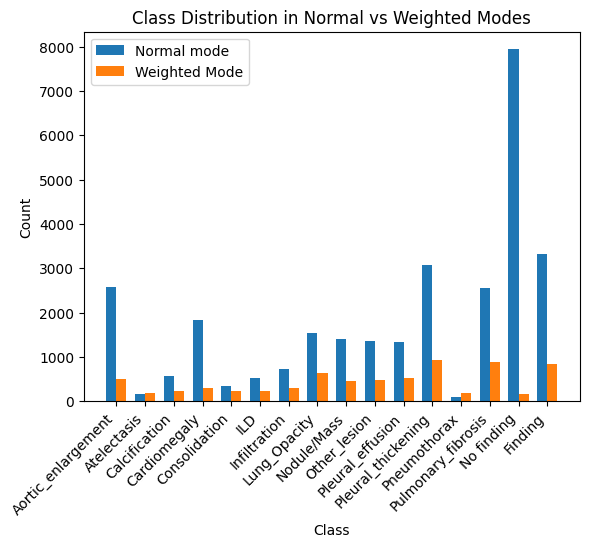

In [26]:
### https://y-t-g.github.io/tutorials/yolo-class-balancing/

# Specify a batch size
batch_size = 16  # or any appropriate value

# # Apply the monkey-patch
# patch_dataset(model.trainer)

if model.trainer is not None:
    patch_dataset(model.trainer)
    # Tiếp tục xây dựng dataset
else:
    print("Trainer chưa được khởi tạo.")

# Now build the dataset with the patched class
trainset = model.trainer.build_dataset('/kaggle/input/vinbigdata-yolo-dataset-with-wbf-640px-16class/vinbigdata-yolo-dataset-with-wbf-640px-16class/train.txt', mode='train', batch=batch_size)

# Now you can proceed to modify the dataset attributes as needed
trainset.agg_func = np.sum
trainset.weights = trainset.calculate_weights()
trainset.probabilities = trainset.calculate_probabilities()

# Verify class balance in training mode
trainset.train_mode = True
train_counts = verify_class_balance(trainset, num_samples=1000)

# Verify class balance in validation mode
trainset.train_mode = False
val_counts = verify_class_balance(trainset, num_samples=1000)

# Plot the comparison
plot_class_balance(train_counts, val_counts, list(trainset.data["names"].values()))

In [27]:
import numpy as np

# Đưa ra ngưỡng riêng cho từng lớp
class_thresholds = [0.5] * len(val_results.box.ap50)  # Khởi tạo ngưỡng mặc định cho tất cả các lớp

for class_id in range(len(val_results.box.ap50)):
    if class_id < len(val_results.box.p):  # Kiểm tra xem class_id có hợp lệ không
        precision = val_results.box.p[class_id]
        recall = val_results.box.r[class_id]
        f1 = val_results.box.f1[class_id]
        
        #  Sử dụng F1 score làm ngưỡng cho mỗi lớp thay vì trung bình của precision và recall. F1 score là một thước đo cân bằng giữa precision và recall.
        #  Đặt ngưỡng tối thiểu là 0.1 để tránh ngưỡng quá thấp có thể dẫn đến quá nhiều dự đoán sai.
        
        # Tính ngưỡng tối ưu dựa trên F1 score
        threshold = f1  # Sử dụng F1 score làm ngưỡng
        
        class_thresholds[class_id] = max(threshold, 0.01)  # Đặt ngưỡng tối thiểu là 0.1

print("Ngưỡng của từng lớp:", class_thresholds)

# Hàm dự đoán với ngưỡng riêng cho từng lớp
def predict_with_thresholds(img_path):
    results = model.predict(img_path, conf=0.01, iou=0.45, agnostic_nms=True, device='0', max_det=300)
    
    boxes = []
    scores = []
    class_ids = []
    
    for result in results:
        for box, score, class_id in zip(result.boxes.xyxy, result.boxes.conf, result.boxes.cls):
            class_id = int(class_id)
            if class_id < len(class_thresholds) and score >= class_thresholds[class_id]:
                boxes.append(box.tolist())
                scores.append(float(score))
                class_ids.append(class_id)
    
    return boxes, scores, class_ids

# Danh sách tên lớp
class_names = ['Aortic_enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly', 'Consolidation', 'ILD', 'Infiltration', 'Lung_Opacity', 'Nodule/Mass', 'Other_lesion', 'Pleural_effusion', 'Pleural_thickening', 'Pneumothorax', 'Pulmonary_fibrosis', 'No finding', 'Finding']

# Dự đoán trên ảnh mới
img_path = '/kaggle/input/vinbigdata-yolo-dataset-with-wbf-640px-16class/vinbigdata-yolo-dataset-with-wbf-640px-16class/test/images/0005e8e3701dfb1dd93d53e2ff537b6e.jpg'
boxes, scores, class_ids = predict_with_thresholds(img_path)

print("Số lượng dự đoán:", len(boxes))
print("\nThông tin chi tiết các hộp dự đoán:")
for i, (box, score, class_id) in enumerate(zip(boxes, scores, class_ids)):
    print(f"Dự đoán {i+1}:")
    print(f"  Hộp giới hạn: {box}")
    print(f"  Độ tự tin: {score:.4f}")
    print(f"  Lớp ID: {class_id}")
    print(f"  Tên lớp: {class_names[class_id]}")
    print()

Ngưỡng của từng lớp: [0.8037647776698476, 0.3088698066808813, 0.316387969428949, 0.8274848603727791, 0.3698186995540763, 0.3818808500645518, 0.41182734488302886, 0.33582849931361275, 0.37900169691830354, 0.26497349279413035, 0.46427795950718176, 0.3413579323027201, 0.42006590542621197, 0.38181554689325375, 0.9777918226727478, 0.9418244956556391]


TypeError: HPYOLOv8.predict() takes 1 positional argument but 2 were given